In [68]:
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
import random
import matplotlib.pyplot as plt

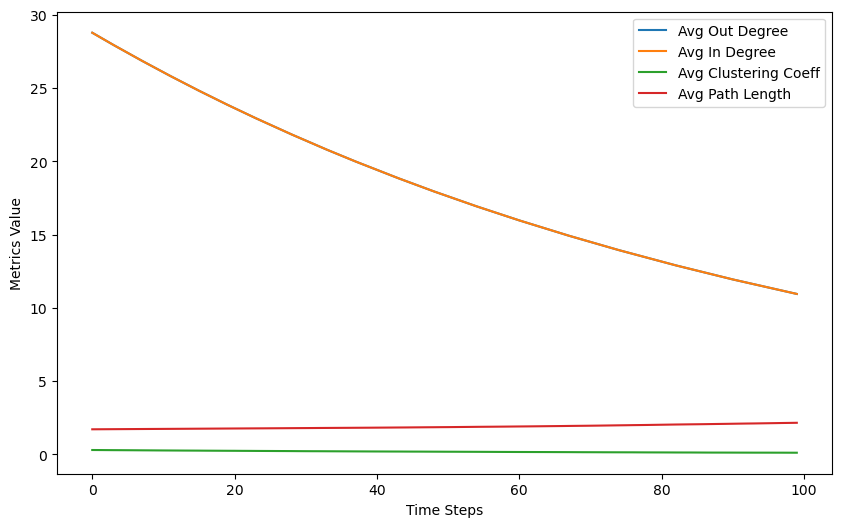

In [69]:
class SocialNetworkAgent(Agent):
    def __init__(self, unique_id, model, influencer, interaction):
        super().__init__(unique_id, model)
        self.influencer = influencer
        self.interaction = interaction

    def step(self):
        if self.influencer:
            self.influencer_behavior()
        else:
            self.non_influencer_behavior()

    def targeted_recommendation(self):
        G = self.model.G
        follower_node = self.unique_id
        follower_neighbors = list(G.predecessors(follower_node))
        
        # Calculate similarity index for each potential influencer
        similarity_scores = {}
        for influencer_node in G.nodes():
            if self.model.agents[influencer_node].influencer and influencer_node not in follower_neighbors:
                common_successors = list(set(G.successors(follower_node)).intersection(set(G.successors(influencer_node))))
                if len(common_successors) > 0:
                    common_successors_sum = sum([0.9 - abs(G.edges[(follower_node, k)]['engagement'] - G.edges[(influencer_node, k)]['engagement']) for k in common_successors])
                    similarity_index = len(common_successors) / (G.out_degree(follower_node) * G.out_degree(influencer_node)) * common_successors_sum
                    similarity_scores[influencer_node] = similarity_index

        # Normalize similarity scores
        total_similarity = sum(similarity_scores.values())
        normalized_scores = {k: v / total_similarity for k, v in similarity_scores.items()} if total_similarity > 0 else {}

        # Choose influencer based on similarity index
        if normalized_scores:
            chosen_influencer = random.choices(list(normalized_scores.keys()), weights=list(normalized_scores.values()), k=1)[0]
        else:
            chosen_influencer = None

        return chosen_influencer

    def influencer_behavior(self):
        neighbors = list(self.model.G.neighbors(self.unique_id))
        if neighbors and random.random() < 0.2:
            target = random.choice(neighbors)
            if random.random() < self.model.G.edges[(self.unique_id, target)]["engagement"]:
                self.model.add_directed_connection(self.unique_id, target)

    def non_influencer_behavior(self):
        if self.interaction == "random":
            neighbors = list(self.model.G.neighbors(self.unique_id))
            if neighbors:
                target = random.choice(neighbors)
                if random.random() < self.model.G.edges[(self.unique_id, target)]["engagement"]:
                    self.model.add_directed_connection(self.unique_id, target)

        elif self.interaction == "targeted":
            chosen_influencer = self.targeted_recommendation()
            if chosen_influencer is not None:
                self.model.G.add_edge(chosen_influencer, self.unique_id, engagement=random.uniform(0.1, 0.9))

class SocialNetworkModel(Model):
    def __init__(self, num_agents, interaction="random"):
        super().__init__()
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.create_random_network()

        if not nx.is_strongly_connected(self.G):
            components = list(nx.strongly_connected_components(self.G))
            largest_component = max(components, key=len)
            self.G = self.G.subgraph(largest_component).copy()

        self.grid = NetworkGrid(self.G)

        for i, node in enumerate(self.G.nodes()):
            in_degree = self.G.in_degree(node)
            influencer = in_degree >= self.get_mean_in_degree()
            agent = SocialNetworkAgent(node, self, influencer, interaction)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.data_collector = {"avg_out_degree": [], "avg_in_degree": [],
                               "avg_clustering_coeff": [], "avg_path_length": []}

    def create_random_network(self):
        self.G = nx.DiGraph()
        undirected_G = nx.erdos_renyi_graph(n=self.num_agents, p=0.3)
        for u, v in undirected_G.edges():
            engagement = random.random()
            self.G.add_edge(u, v, engagement=engagement)
            self.G.add_edge(v, u, engagement=engagement)

    def add_directed_connection(self, from_node, to_node):
        if not self.G.has_edge(from_node, to_node):
            self.G.add_edge(from_node, to_node, engagement=random.random())

    def get_mean_in_degree(self):
        degrees = [val for (node, val) in self.G.in_degree()]
        mean_degree = sum(degrees) / len(degrees)
        return mean_degree

    def step(self):
        self.schedule.step()
        self.track_metrics()
        self.prune_network()

    def track_metrics(self):
        avg_out_degree = sum(dict(self.G.out_degree()).values()) / self.num_agents
        avg_in_degree = sum(dict(self.G.in_degree()).values()) / self.num_agents
        avg_clustering_coeff = nx.average_clustering(self.G)
        avg_path_length = nx.average_shortest_path_length(self.G)

        self.data_collector["avg_out_degree"].append(avg_out_degree)
        self.data_collector["avg_in_degree"].append(avg_in_degree)
        self.data_collector["avg_clustering_coeff"].append(avg_clustering_coeff)
        self.data_collector["avg_path_length"].append(avg_path_length)

    def prune_network(self):
        edges = list(self.G.edges())
        num_edges_to_remove = len(edges) // self.num_agents
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        self.G.remove_edges_from(edges_to_remove)

# Running the model
model = SocialNetworkModel(num_agents=100, interaction="random")
for i in range(100):
    model.step()
    pos = nx.spring_layout(model.G)
    #nx.draw(model.G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_color="black")
    #plt.show()

# Example of how to plot metrics
plt.figure(figsize=(10, 6))
plt.plot(model.data_collector["avg_out_degree"], label="Avg Out Degree")
plt.plot(model.data_collector["avg_in_degree"], label="Avg In Degree")
plt.plot(model.data_collector["avg_clustering_coeff"], label="Avg Clustering Coeff")
plt.plot(model.data_collector["avg_path_length"], label="Avg Path Length")
plt.xlabel("Time Steps")
plt.ylabel("Metrics Value")
plt.legend()
plt.show()
